In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt

C:\Users\malce\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Building The Network

In [2]:
class Network(nn.Module):
  def __init__(self):
    super(Network, self).__init__()
    self.dropout = nn.Dropout(0.2)
    self.lin1 = nn.Linear(200,64)
    self.lin2 = nn.Linear(64,32)
    self.lin3 = nn.Linear(32,4)

  def forward(self, x):   
    x = F.relu(self.lin1(x))
    x = F.relu(self.lin2(x))
    x = self.dropout(x) 
    x = F.sigmoid(self.lin3(x))
    return x

In [3]:
def train(net, dataset, optimizer):
  net.train()
  total_loss = 0
  for input, target in dataset:
    input = Variable(input).cuda()
    output = net(input)
    target = Variable(target).cuda()
    criterion = nn.MSELoss()
    loss = criterion(output, target)
    total_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print( "train loss:", (total_loss/len(dataset)))
  return (total_loss/len(dataset))

In [4]:
def test(net, dataset):
  net.eval()
  total_loss = 0
  for input, target in dataset:
    input = Variable(input).cuda()
    output = net(input)
    target = Variable(target).cuda()
    criterion = nn.MSELoss()
    loss = criterion(output, target)
    total_loss += loss.item()
  print("test loss:", (total_loss/len(dataset)))
  return (total_loss/len(dataset))

Loading the data

In [5]:
input = pd.read_table("../data/training/train_data_ATAC_200.txt", sep = " ", header=0)
labels = pd.read_csv("../data/pre_processed/ATAC_annotations.csv")
codes, uniques = labels["Trajectory"].factorize()

In [6]:
class Custom_Dataset(Dataset):
    def __init__(self, input, labels):
        dist_labels = torch.Tensor([[1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,1]])
        self.X = [torch.Tensor(row.tolist()) for indx, row in input.iterrows()]
        self.y = [dist_labels[label] for label in labels]
        print(f"Dataset size: X={len(self.X)}, y={len(self.y)}")

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return len(self.X)

In [7]:
data = Custom_Dataset(input, codes)

train_dataset, test_dataset = random_split(data, [0.7, 0.3])

data_loader_train = DataLoader(train_dataset, batch_size=64, shuffle=True)
data_loader_test = DataLoader(test_dataset, batch_size=64, shuffle=True)

Dataset size: X=17278, y=17278


Training

In [12]:
net = Network()
net = net.cuda()
optimizer = optim.Adam(net.parameters(), lr = 0.001)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,30,70], gamma=0.1)

train_loss = []
test_loss = []

for epoch in range(100):
  print("epoch:", epoch+1)
  tr_loss = train(net, data_loader_train, optimizer)
  te_loss = test(net, data_loader_test)
  train_loss.append(tr_loss)
  test_loss.append(te_loss)
  scheduler.step()

np.savez('Learning_Curves_ATAC.npz', train_loss=train_loss, test_loss=test_loss)
torch.save(net, 'saved_net_ATAC.py')

epoch: 1
train loss: 0.12009418186135393
test loss: 0.07465946724937286
epoch: 2
train loss: 0.0765772560640933
test loss: 0.07787412998301012
epoch: 3
train loss: 0.0694049295412485
test loss: 0.0635857904030953
epoch: 4
train loss: 0.06430741081201526
test loss: 0.06407866291241882
epoch: 5
train loss: 0.06308121690477328
test loss: 0.06003837908307711
epoch: 6
train loss: 0.056854092097156264
test loss: 0.05884661470298414
epoch: 7
train loss: 0.056016165506902825
test loss: 0.058752537417558974
epoch: 8
train loss: 0.05547157343890932
test loss: 0.05836915698500327
epoch: 9
train loss: 0.05475898557120845
test loss: 0.05832626856863499
epoch: 10
train loss: 0.055305850677310475
test loss: 0.05825584050681856
epoch: 11
train loss: 0.054176786106336056
test loss: 0.058361401183553686
epoch: 12
train loss: 0.05384526189869989
test loss: 0.05787346691445068
epoch: 13
train loss: 0.05358139107191058
test loss: 0.0580322121810398
epoch: 14
train loss: 0.05285309618782429
test loss: 0.057

Evaluation

0.850665637661586


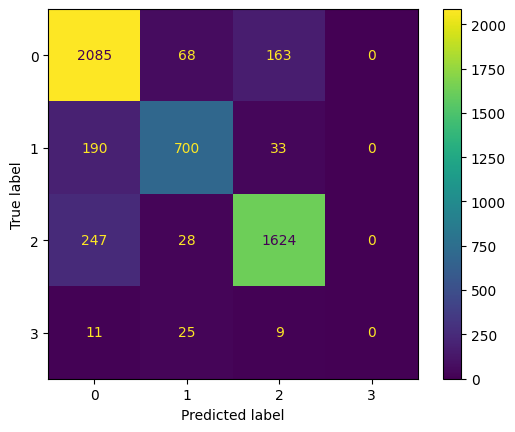

In [13]:
net.cpu()

X = [i for i,j in test_dataset]
pred = [net(x) for x in X]
y_true = [np.argmax(j) for i,j in test_dataset]
y_pred = [np.argmax(i.detach().numpy()) for i in pred]

acc = accuracy_score(y_true, y_pred)

print(acc)

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.savefig("conf_mat_ATAC_200.png")
plt.show()

Interpretability

In [8]:
net = torch.load("saved_net_ATAC.py").cpu()
ig = IntegratedGradients(net)
net.eval()
res = np.zeros((4, 200))

for input, target in test_dataset:
    input = input.unsqueeze(0)
    target = torch.argmax(target).unsqueeze(0)
    attributions, delta = ig.attribute(input, target = target, return_convergence_delta=True)
    res[target] += np.array(attributions[0])


KeyboardInterrupt: 

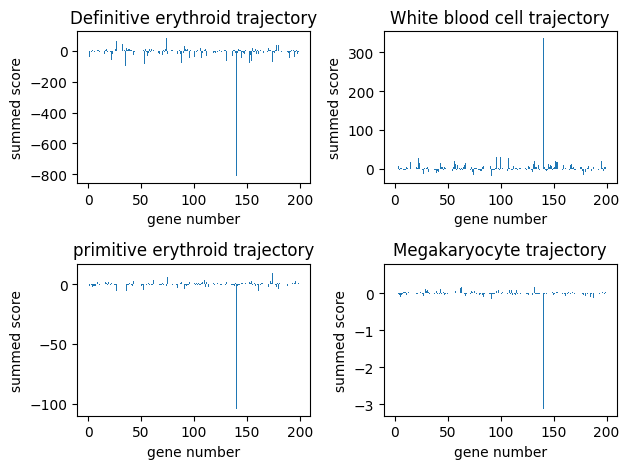

<Figure size 640x480 with 0 Axes>

In [15]:
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title(uniques[i])
    plt.xlabel("gene number")
    plt.ylabel("summed score")
    plt.bar(np.arange(200), res[i])

plt.tight_layout()
plt.savefig("attributions_ATAC.png")
plt.show()

In [16]:
top_10 = np.zeros((4, 10))

for i in range(4):
    ind = np.argpartition(res[i], -10)[-10:]
    top_10[i] = ind

top_10 = top_10.astype('int32')

In [17]:
genes = pd.read_csv("../DESeq/genes_by_sig_unique_ATAC.csv")

important_genes = pd.DataFrame({"gene_name": [],
                               "class" : [],
                               "score" : []})

In [18]:
for i in range(4):
    for j in range(10):
        gene_name = genes.loc[top_10[i,j], "gene"]
        clas = uniques[i]
        score = res[i, top_10[i,j]]
        important_genes.loc[len(important_genes.index)] = [gene_name, clas, score]
        

In [19]:
important_genes

,gene_name,class,score
0,Dleu2,Definitive erythroid trajectory,18.463803
1,Fars2,Definitive erythroid trajectory,19.989034
2,Mllt3,Definitive erythroid trajectory,20.718992
3,Atp2b4,Definitive erythroid trajectory,28.266696
4,Fryl,Definitive erythroid trajectory,43.689745
5,Zfp608,Definitive erythroid trajectory,29.487833
6,Hk1,Definitive erythroid trajectory,66.049328
7,Arfip1,Definitive erythroid trajectory,38.117065
8,Tnrc6b,Definitive erythroid trajectory,81.460501
9,Arhgap23,Definitive erythroid trajectory,37.795679


In [21]:
important_genes.to_csv("important_genes_ATAC.csv")